<a href="https://colab.research.google.com/github/wheyland/poker/blob/main/DQN_Test_Sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip3 install rlcard[torch]

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import argparse

import rlcard
from rlcard.agents import (
    RandomAgent,
    DQNAgent
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
    reorganize,
)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [26]:
class LSTMDQNAgent(DQNAgent):
    def __init__(self,
                 num_opponents=1,
                 lstm_input_size=4,
                 lstm_hidden_size=64,
                 fusion_hidden_size=128,  # New: hidden size for final fusion FC
                 *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_opponents = num_opponents
        self.lstm_input_size = lstm_input_size
        self.lstm_hidden_size = lstm_hidden_size

        self.device = self.device if hasattr(self, 'device') else torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.opponent_lstms = nn.ModuleList([
            nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
            for _ in range(num_opponents)
        ]).to(self.device)

        self.opponent_histories = [[] for _ in range(num_opponents)]

        # fc layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.num_actions + num_opponents * lstm_hidden_size, fusion_hidden_size),
            nn.ReLU(),
            nn.Linear(fusion_hidden_size, self.num_actions)
        ).to(self.device)

    def reset_histories(self):
        self.opponent_histories = [[] for _ in range(self.num_opponents)]
        self._last_action_index = 0

    def add_to_history(self, opponent_id, action_onehot):
        if 0 <= opponent_id < self.num_opponents:
            self.opponent_histories[opponent_id].append(action_onehot)

    def update_histories_from_action_record(self, action_record):
        '''Update histories using new entries in action record'''
        new_actions = action_record[self._last_action_index:]
        self._last_action_index = len(action_record)

        for player_id, action_str in new_actions:
            if player_id != 0:  # Assume agent ID 0
                action_vector = self.encode_action(action_str)
                self.add_to_history(player_id-1, action_vector)

    def encode_action(self, action_str):
        action_map = {
            'fold': [1, 0, 0, 0],
            'check': [0, 1, 0, 0],
            'call': [0, 0, 1, 0],
            'raise': [0, 0, 0, 1],
        }
        return np.array(action_map.get(action_str, [0, 0, 0, 0]))

    def _build_opponent_embeddings(self):
        '''Build embeddings by feeding opponent histories into their LSTMs.'''
        embeddings = []
        for idx, lstm in enumerate(self.opponent_lstms):
            hist = self.opponent_histories[idx]
            if len(hist) == 0:
                embeddings.append(torch.zeros((1, self.lstm_hidden_size), device=self.device))
            else:
                hist_tensor = torch.FloatTensor(hist).unsqueeze(0).to(self.device)
                _, (h_n, _) = lstm(hist_tensor)
                embeddings.append(h_n.squeeze(0).unsqueeze(0))  # (1, hidden_size)
        return torch.cat(embeddings, dim=1)  # (1, total_lstm_size)

    def predict(self, state):
        '''Override predict: do late fusion with LSTM outputs.'''
        obs = torch.FloatTensor(state['obs']).unsqueeze(0).to(self.device)  # (1, obs_dim)

        # First, use DQN to get initial Q-values
        initial_q_values = self.q_estimator.predict_nograd(obs.cpu().numpy())
        initial_q_values = torch.FloatTensor(initial_q_values).to(self.device)  # (1, num_actions)

        # Build opponent embeddings
        opponent_summary = self._build_opponent_embeddings()  # (1, num_opponents * lstm_hidden_size)

        # Concatenate
        combined = torch.cat([initial_q_values, opponent_summary], dim=1)  # (1, num_actions + opponent summary)

        # Pass through fusion layer
        final_q_values = self.fusion_layer(combined).squeeze(0)  # (num_actions,)

        # Mask illegal actions
        masked_q_values = -np.inf * np.ones(self.num_actions, dtype=float)
        legal_actions = list(state['legal_actions'].keys())
        final_q_values = final_q_values.detach().cpu().numpy()
        masked_q_values[legal_actions] = final_q_values[legal_actions]
        return masked_q_values

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  -0.2945
----------------------------------------
INFO - Step 100, rl-loss: 1637.3931884765625
INFO - Copied model parameters to target network.
INFO - Step 1099, rl-loss: 3100.54296875
INFO - Saved model checkpoint.
INFO - Step 1100, rl-loss: 2837.50146484375
INFO - Copied model parameters to target network.
Iteration 1000
----------------------------------------
  episode      |  1000
  reward       |  1.015
----------------------------------------
INFO - Step 2099, rl-loss: 1897.228271484375
INFO - Saved model checkpoint.
INFO - Step 2100, rl-loss: 2525.747802734375
INFO - Copied model parameters to target network.
Iteration 2000
----------------------------------------
  episode      |  2000
  reward       |  0.8845
----------------------------------------
INFO - Step 3099, rl-loss: 2179.37109375
INFO - Saved model checkpoint.
INFO - Step 3100, rl-loss: 2009.4700927734375
INFO - Copied model p

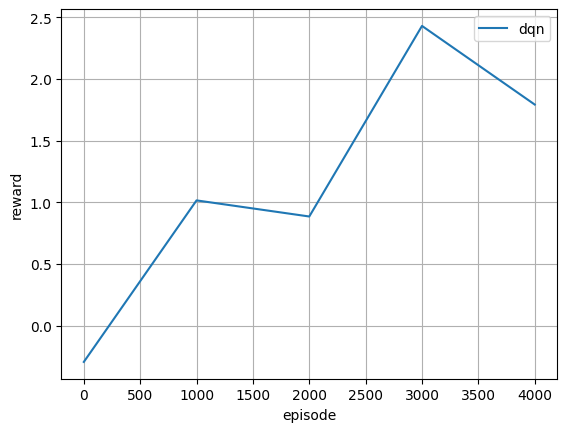

In [30]:
import os
import argparse

import rlcard
from rlcard.agents import (
    RandomAgent,
    DQNAgent
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
    reorganize,
)

def train(agent_type, game_type = 'no-limit-holdem', seed = 42, num_episodes = 5000, evaluate_every = 1000, num_eval_games = 2000, log_dir = "cfr/"):
    env = rlcard.make(
        game_type,
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )

    eval_env = rlcard.make(
        game_type,
        config={
            'seed': 0,
        }
    )

    set_seed(seed)

    #agent.load()  # Load a saved model if available
    if agent_type == "dqn":

      agent = LSTMDQNAgent(
          num_actions=env.num_actions,
          state_shape=env.state_shape[0],
          mlp_layers=[64,64],
          save_path = log_dir,
          save_every = num_episodes / 5,
          num_opponents=2
      )

      env.set_agents([agent, agent])

    # Set evaluation environment agents
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    # Start training process
    with Logger(log_dir) as logger:
        for episode in range(num_episodes):
            if agent_type == "cfr":
              agent.train()
            elif agent_type == "dqn":
              trajectories, payoffs = env.run(is_training=True)



              # state, action, reward, next_state, done format
              trajectories = reorganize(trajectories, payoffs)

              # Feed transitions into agent memory and train the agent
              for ts in trajectories[0]:
                  agent.feed(ts)

            print('\rIteration {}'.format(episode), end='')
            # Periodically evaluate the agent's performance against random agents
            if episode % evaluate_every == 0:
                if agent_type == "cfr":
                  agent.save()  # Save the model

                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        num_eval_games
                    )[0]
                )

        # Retrieve paths for logging data
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve based on logged performance data
    plot_curve(csv_path, fig_path, agent_type)

    return agent


agent_type = "dqn"
game_type = "no-limit-holdem"
agent = train(agent_type, game_type = game_type, num_episodes = 5000, log_dir = agent_type + "-" + game_type + "/")


Play No-Limit Texas Hold-em against your AI

In [6]:
!pip3 install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 14.7 MB/s eta 0:00:00


In [7]:
import pettingzoo
from pettingzoo.classic import texas_holdem_no_limit_v6

In [35]:
import rlcard
import torch
from rlcard import models
from rlcard.agents import NolimitholdemHumanAgent, RandomAgent
from rlcard.utils import print_card

env = rlcard.make('no-limit-holdem')

# Set up random opponents
random1 = RandomAgent(num_actions=env.num_actions)
random2 = RandomAgent(num_actions=env.num_actions)
random3 = RandomAgent(num_actions=env.num_actions)
random4 = RandomAgent(num_actions=env.num_actions)

# Load your LSTM-enhanced DQN agent


# Set agents
env.set_agents([
    agent,
    random1,
    random2,
    random3,
    random4
])

print(">> Play No-Limit Texas Holdem against random agents")

def evaluate(agent, env, num_games=10000):
    '''Evaluate agent performance by playing num_games against random opponents.'''

    total_reward = 0

    for _ in range(num_games):
        agent.reset_histories()  # Important: reset LSTM hidden states

        trajectories, payoffs = env.run(is_training=False)

        final_state = trajectories[0][-1]

        agent.update_histories_from_action_record(final_state['action_record'])  # Update histories (optional but good)

        # Assume agent is always player 0
        total_reward += payoffs[0]

    avg_reward = total_reward / num_games
    print(f"Evaluation over {num_games} games: Avg reward = {avg_reward:.3f}")

    return avg_reward

evaluate(agent, env)


>> Play No-Limit Texas Holdem against random agents
Evaluation over 10000 games: Avg reward = 5.536


np.float64(5.5363)